In [1]:
import pathlib
import sys
from collections import defaultdict
import argparse
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset import SliceDataDev
from models import DnCn
import h5py
from tqdm import tqdm
import transforms as T
from matplotlib import pyplot as plt

In [2]:
class DataTransform:
    """
    Data Transformer for training U-Net models.
    """

    def __init__(self, resolution, which_challenge, mask_func=None, use_seed=True):
        """
        Args:
            mask_func (common.subsample.MaskFunc): A function that can create a mask of
                appropriate shape.
            resolution (int): Resolution of the image.
            which_challenge (str): Either "singlecoil" or "multicoil" denoting the dataset.
            use_seed (bool): If true, this class computes a pseudo random number generator seed
                from the filename. This ensures that the same mask is used for all the slices of
                a given volume every time.
        """
        if which_challenge not in ('singlecoil', 'multicoil'):
            raise ValueError(f'Challenge should either be "singlecoil" or "multicoil"')
        self.mask_func = mask_func
        self.resolution = resolution
        self.which_challenge = which_challenge
        self.use_seed = use_seed

    def __call__(self, kspace, mask, target, attrs, fname, slice):
        """
        Args:
            kspace (numpy.array): Input k-space of shape (num_coils, rows, cols, 2) for multi-coil
                data or (rows, cols, 2) for single coil data.
            mask (numpy.array): Mask from the test dataset
            target (numpy.array): Target image
            attrs (dict): Acquisition related information stored in the HDF5 object.
            fname (str): File name
            slice (int): Serial number of the slice.
        Returns:
            (tuple): tuple containing:
                image (torch.Tensor): Zero-filled input image.
                target (torch.Tensor): Target image converted to a torch Tensor.
                mean (float): Mean value used for normalization.
                std (float): Standard deviation value used for normalization.
        """
        kspace = T.to_tensor(kspace)
        # Apply mask
        if self.mask_func:
            seed = None if not self.use_seed else tuple(map(ord, fname))
            masked_kspace, mask = T.apply_mask(kspace, self.mask_func, seed)
        else:
            masked_kspace = kspace
            mask = torch.from_numpy(mask[:, np.newaxis].astype(np.float32))

        mask = mask.repeat(kspace.shape[0],1,1) # 640 is fixed for single coil 

        # Inverse Fourier Transform to get zero filled solution
        image = T.ifft2(masked_kspace)
        
        # Complex abs
        image_abs = T.complex_abs(image)
        image_abs_max = image_abs.max()
        
        # Image and kspace normalization
        image_norm = image / image_abs_max
        masked_kspace_norm = masked_kspace / image_abs_max
                
        # Crop input image to given resolution if larger
        smallest_width = min(self.resolution, image.shape[-2])
        smallest_height = min(self.resolution, image.shape[-3])
        
        if target is not None:
            smallest_width = min(smallest_width, target.shape[-1])
            smallest_height = min(smallest_height, target.shape[-2])

        crop_size = (smallest_height, smallest_width)
        crop_size_tensor = torch.Tensor(crop_size)
        
        image_norm_crop = T.complex_center_crop(image_norm, crop_size)
        kspace_norm_crop = T.fftshift(T.fft2(image_norm_crop))
        
        if target is not None:
            target = T.to_tensor(target)
            target_norm = target / image_abs_max
        else:
            target_norm = torch.Tensor([0])
            
        return image_norm_crop, kspace_norm_crop, image_norm, masked_kspace_norm, target_norm, mask, image_abs_max, crop_size_tensor, fname, slice


In [3]:
checkpoint = torch.load('/media/htic/NewVolume2/balamurali/fastmri_experiments/dc_rsn/best_model.pt')
args = checkpoint['args']
model = DnCn(args).to(args.device)    
model.load_state_dict(checkpoint['model'])

In [4]:
transform = DataTransform(320, 'singlecoil')

data = SliceDataDev('/media/htic/NewVolume5/fastmri/singlecoil_test_v2',transform=transform)
data_loader = DataLoader(
    dataset=data,
    batch_size=1,
    num_workers=1,
    pin_memory=True,
    shuffle=True)

  0%|          | 0/3903 [00:00<?, ?it/s]

(320, 320) torch.Size([1, 2, 320, 320]) torch.Size([1, 2, 320, 320]) torch.Size([1, 640, 368, 2]) torch.Size([1, 640, 368, 1])
(320, 320) (320, 320) (320, 320) (640, 368) (640, 368)


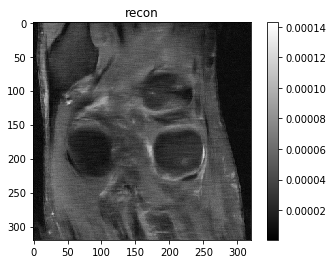

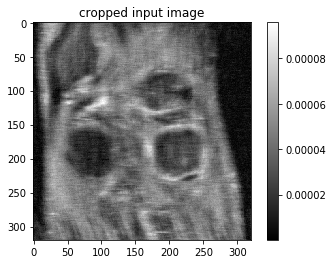

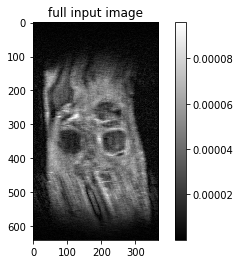

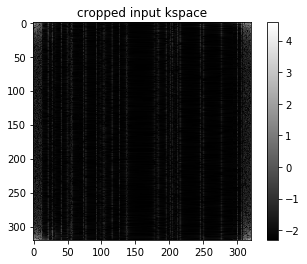

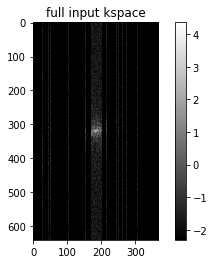

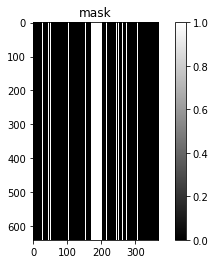

In [33]:
model.eval()
reconstructions = defaultdict(list)

with torch.no_grad():
    for (iter,data) in enumerate(tqdm(data_loader)):

        image_crop, kspace_crop, image, kspace, target, mask, abs_max, crop_size_tensor, fnames, slices = data

        image_crop = image_crop.permute(0, 3, 1, 2).to(args.device)
        kspace_crop = kspace_crop.permute(0, 3, 1, 2).to(args.device)
        kspace = kspace.to(args.device)
        image = image.permute(0, 3, 1, 2).to(args.device)
        target = target.to(args.device)
        mask = mask.to(args.device)
        abs_max = abs_max.to(args.device)

        crop_size = (int(crop_size_tensor.numpy()[0,0]), int(crop_size_tensor.numpy()[0,1]))

        #print (image_crop.shape, kspace_crop.shape, image.shape, kspace.shape, mask.shape, crop_size_tensor.shape)
        output = model(image_crop, kspace_crop, image, kspace, mask, crop_size)
        
        output = T.complex_abs(output.permute(0,2,3,1))
        
        recons = output * abs_max
        recons = recons.to('cpu').numpy()[0]
        
        print (recons.shape, image_crop.shape, kspace_crop.shape, kspace.shape, mask.shape)
        
        
        
        ## numpy
        image_crop = T.complex_abs(image_crop.permute(0,2,3,1))
        image_crop = image_crop * abs_max
        image_crop = image_crop.to('cpu').numpy()[0]
        
        kspace_crop = kspace_crop.to('cpu').numpy()[0]
        kspace_crop = kspace_crop[0] + 1j * kspace_crop[1]
        
        image = T.complex_abs(image.permute(0,2,3,1))
        image = image * abs_max
        image = image.to('cpu').numpy()[0]

        kspace = kspace.to('cpu').numpy()[0]
        kspace = kspace[:,:,0] + 1j * kspace[:,:,1]

        mask = mask.to('cpu').numpy()[0,:,:,0]
        
        print (recons.shape, image_crop.shape, kspace_crop.shape, kspace.shape, mask.shape)
        
        plt.figure()
        plt.title('recon')
        plt.imshow(recons,cmap='gray')
        plt.colorbar()
        
        plt.figure()
        plt.title('cropped input image')
        plt.imshow(image_crop,cmap='gray')
        plt.colorbar()
        
        plt.figure()
        plt.title('full input image')
        plt.imshow(image,cmap='gray')
        plt.colorbar()
        
        plt.figure()
        plt.title('cropped input kspace')
        plt.imshow(np.log(np.abs(kspace_crop) + 0.1),cmap='gray')
        plt.colorbar()
        
        plt.figure()
        plt.title('full input kspace')
        plt.imshow(np.log(np.abs(kspace) + 0.1),cmap='gray')
        plt.colorbar()
        
        plt.figure()
        plt.title('mask')
        plt.imshow(mask,cmap='gray')
        plt.colorbar()
            
        
        
#         image_crop = image_crop * abs_max
#         image_crop = image_crop[0].to('cpu').numpy()
        
#         image = image * abs_max
#         image = image[0].to('cpu').numpy()
        
#         kspace_crop = kspace_crop * abs_max
#         kspace_crop = kspace_crop[0].to('cpu').numpy()
        
#         plt.figure()
#         plt.imshow(img_np, cmap='gray')
#         plt.colorbar()
#         plt.figure()
#         plt.imshow(recons_np, cmap='gray')
#         plt.colorbar()
        
#         print (fnames, slices)
        

#         for i in range(recons.shape[0]):
#             recons[i] = recons[i] 
#             reconstructions[fnames[i]].append((slices[i].numpy(), recons[i].numpy()))
            
        break

# reconstructions = {
#     fname: np.stack([pred for _, pred in sorted(slice_preds)])
#          for fname, slice_preds in reconstructions.items()
#      }

/home/htic/anaconda2/envs/torch4/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


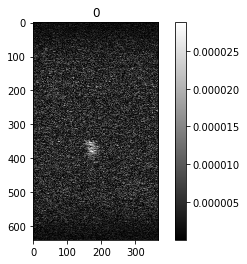

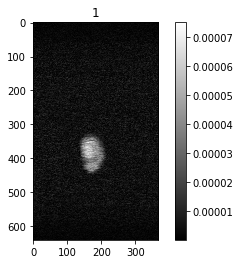

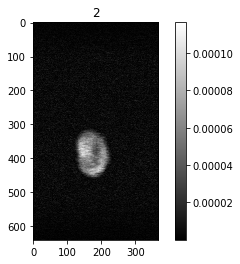

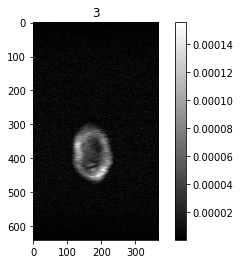

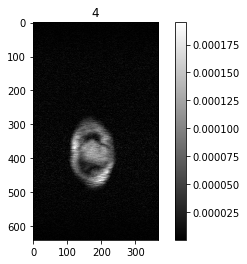

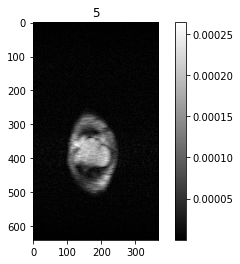

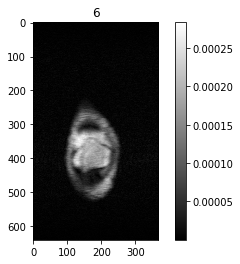

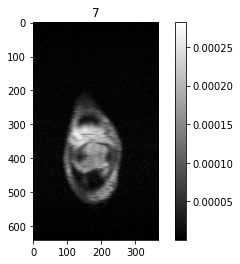

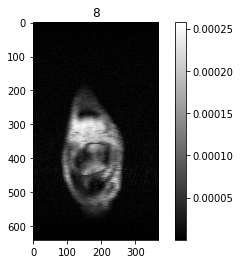

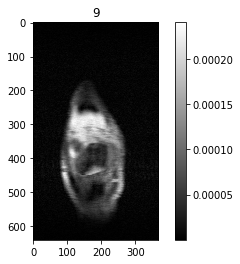

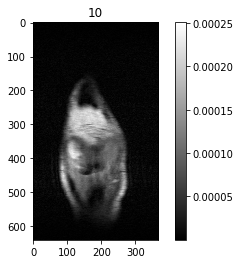

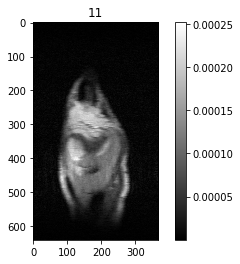

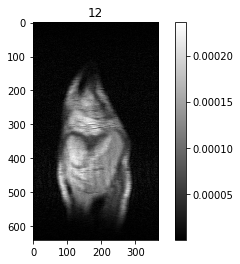

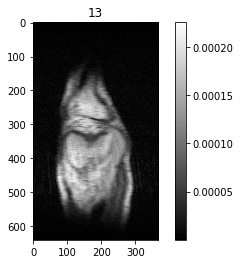

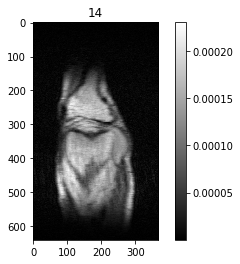

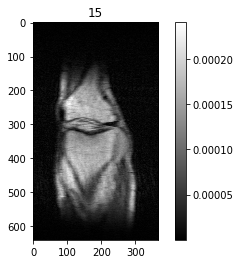

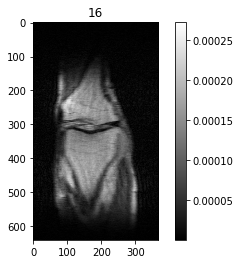

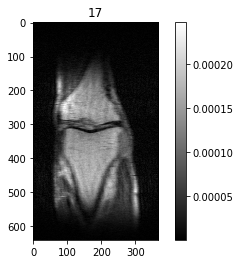

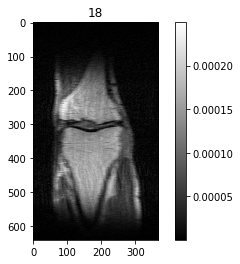

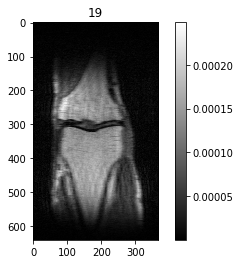

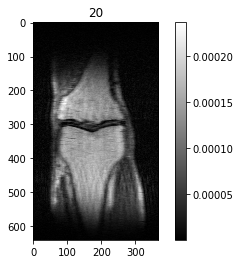

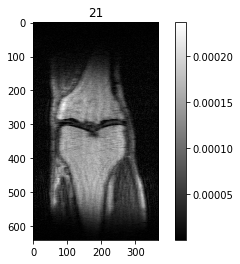

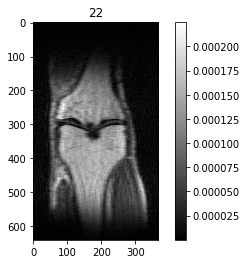

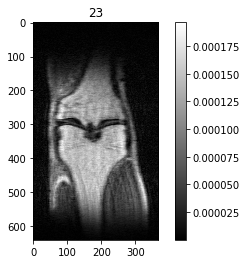

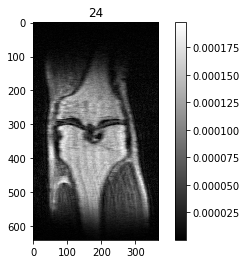

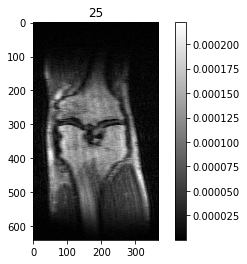

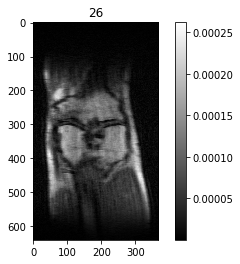

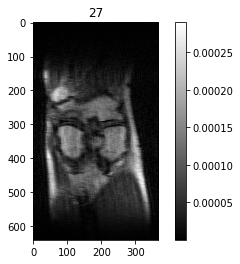

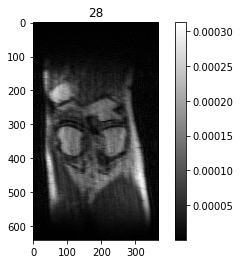

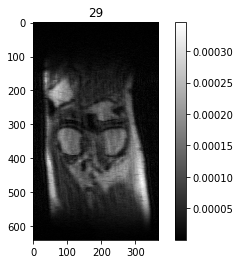

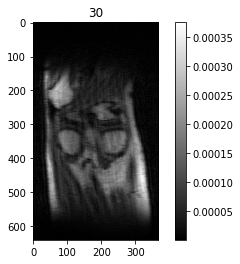

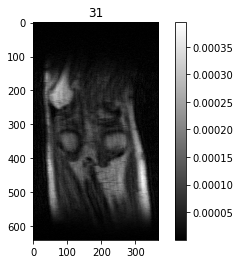

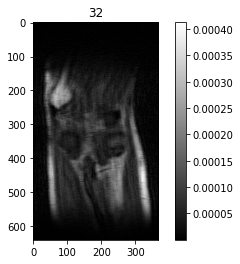

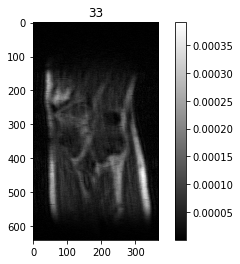

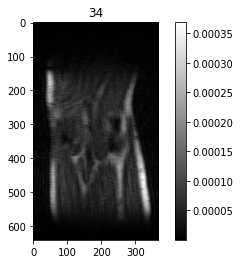

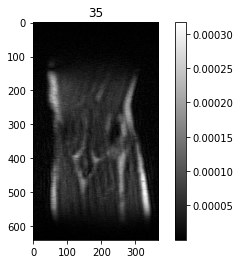

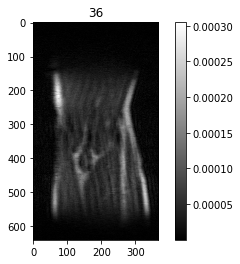

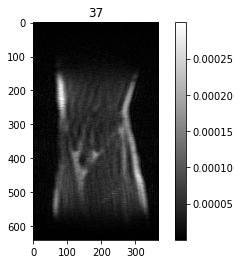

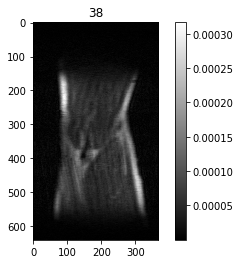

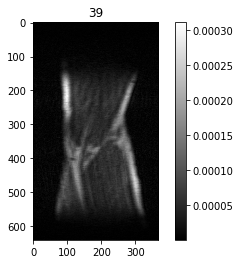

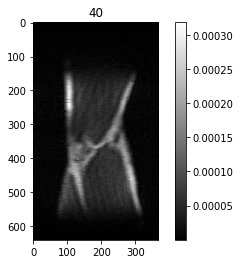

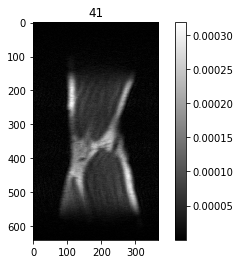

In [6]:
with h5py.File('/media/htic/NewVolume5/fastmri/singlecoil_test_v2/file1001072_v2.h5','r') as hf:
    img_abs = np.abs(np.fft.ifftshift(np.fft.ifft2(hf['kspace'],norm='ortho'),axes=(1,2)))
    for ii in range(img_abs.shape[0]):
        plt.figure()
        plt.title(str(ii))
        plt.imshow(img_abs[ii,:,:],cmap='gray')
        plt.colorbar()

(42, 640, 368)


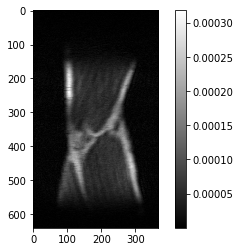

In [8]:
with h5py.File('/media/htic/NewVolume5/fastmri/singlecoil_test_v2/file1001072_v2.h5','r') as hf:
    img_abs = np.abs(np.fft.ifftshift(np.fft.ifft2(hf['kspace'],norm='ortho'),axes=(1,2)))
    print (img_abs.shape)
    plt.imshow(img_abs[40,:,:],cmap='gray')
    plt.colorbar()